# Project: Investigate a Dataset (TMDB movies dataset)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I chose to investigate the TMBD movie dataset. This dataset contains information related to arround 10,000 movies collected from "The Movie Database" (TMDb). It includes information about movie's budget, revenue, viewer's rating, genre, companies, casting etc...

This dataset can help to understand what are the factors contributing to the profitability (revenue - budget) of a movie. I chose to focus on the profitability as the main dependent variable.

### Questions 

<li><a href="#Q1">1. What are the most and the least profitable movies ?</a></li>
<li><a href="#Q2">2. What is the distribution of all movies profits ?</a></li>
<li><a href="#Q3">3. Are the most profitable movies also the better rated ?</a></li>
<li><a href="#Q4">4. During which months are the most profitable movies released ?</a></li>
<li><a href="#Q5">5. What are the genres that generated the most profits ?</a></li>
<li><a href="#Q6">6. Is there is a correlation between profit and number of movies for each genre ?</a></li>
<li><a href="#Q7">7. What are the casts, directors and production companies which have generated the most profits ?</a></li>

In [41]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 

%matplotlib inline

# Style and size of graph
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,8)})

<a id='wrangling'></a>
## Data Wrangling 

During this step, we are going to import the csv file and display its main information. We will perform the following steps:

- Display the info of the dataset (number of rows and columns, data types and format...).
- Check number of 0 values and NaN.
- Check duplicated rows.
- Check the description of numerical data.
- Search for outliers.

### General Properties

First, let's read the .csv and import it in a Pandas DataFrame. Then we can display the 5 first rows:

In [42]:
# Reading the csv file and importing it to a dataframe
df = pd.read_csv('tmdb-movies.csv')
# Displaying first rows
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


We can make several observations:

- The "cast", "director", "genres" and "production companies" format are made of several names separated by "|". The data handling would be easier by transforming this format into lists.
- The columns "imdb_id", "homepage", "tagline", "overview" and "keywords" are not relevant for this analysis, we can remove them.
- The "id" columns could be removed if there are no identical names for 2 or more movies (to be checked)
- The budget_adj and revenue_adj are displayed in scientific format. As we can assume that these number are in USD, they will be easier to read in a standard format.
- As we are comparing movies from different periods, we should keep the adjusted budgets and revenues to account for the inflation over years.

Now we can get some information about this dataset:

In [43]:
# Displaying the shape of the dataframe, the number of elements per column and the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

Some columns have a significant number of missings but fortunately, these are mainly the ones we are going to drop.   
Now we can display the number of zeroes in the different columns:

In [44]:
# Showing the number of 0 in each column
df.isin([0]).sum()

id                         0
imdb_id                    0
popularity                 0
budget                  5696
revenue                 6016
original_title             0
cast                       0
homepage                   0
director                   0
tagline                    0
keywords                   0
overview                   0
runtime                   31
genres                     0
production_companies       0
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj              5696
revenue_adj             6016
dtype: int64

Lots of budget and revenue are at 0 which means that they are most likely missing (difficult to imagine a movie with 0 budget). As the investigation we gonna perform involves mainly movies profits, it is better to keep only rows for which both revenue and budget are available.   
Then, we can find the number of NaN in our dataset:

In [45]:
# Counting the number of NaN in each column
df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

There are few missings in cast, director, genres and production companies. We should fill these cells with a str "not_specified".
We can now check the number of duplicate rows:

In [46]:
# Showing the number of duplicated rows (returns True if a row is duplicated)
(df.duplicated()).value_counts()

False    10865
True         1
dtype: int64

There is only 1 duplicated row. We will remove it during data cleaning phase.  
We can then have an overlook at the numerical stats of the dataframe:

In [47]:
# Displaying the statistics of each numerical column
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


The budget and revenue first quartiles and medians are equal to 0 which is not surprising as more than half the rows have a budget or revenue value at 0. Let's display the revenue in function of budget in log scale to see if there are abnormal points (apart from the ones equal to 0). The graph will be more readable in log-log scale as we want to check low values.

Text(0, 0.5, 'Revenue adjusted')

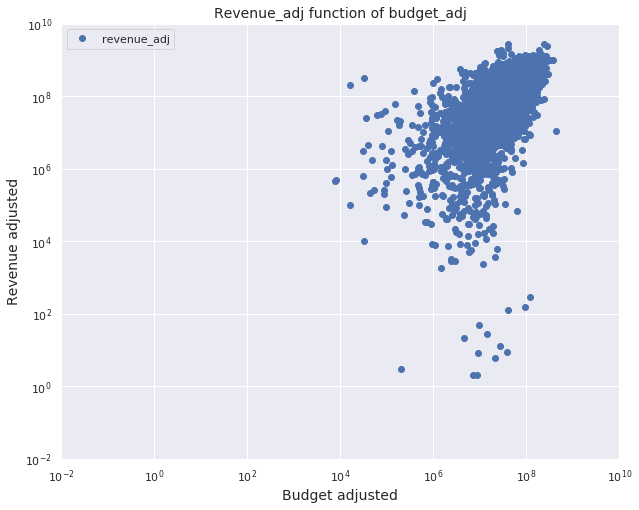

In [86]:
# Scatter plot in log-log scale
df.plot(x = 'budget_adj', y = 'revenue_adj', style = 'o')
# Graph features
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,1E10)
plt.ylim(0.01,1E10)
plt.title('Revenue_adj function of budget_adj', fontsize = 14)
plt.xlabel('Budget adjusted', fontsize = 14)
plt.ylabel('Revenue adjusted', fontsize = 14)

There seems to be some strange points like, for instance, movies with a budget arround 100 USD generating revenue arround 10,000,000 USD. These points are most likely outliers in the database. We can display the dataset with budget and revenue different from 0 sorted by lowest budget.

In [49]:
# Generating a dataframe without any budget or revenue equal to 0
filtered_df = df[(df['budget_adj'] != 0) & (df['revenue_adj'] != 0)]

# Displaying the 10 lowest budget and revenue movies from this extract_df
filtered_df[
    ['budget_adj', 'revenue_adj', 'original_title', 'director', 'release_year']
].sort_values(['budget_adj', 'revenue_adj'], ascending = True).head(10)

,budget_adj,revenue_adj,original_title,director,release_year
3581,0.969398,1335.830503,"Love, Wedding, Marriage",Dermot Mulroney,2011
2618,1.309053,130.905285,Lost & Found,Jeff Pollack,1999
2398,3.000000,43.000000,Boy,Taika Waititi,2010
8944,4.519285,36.154278,Death Wish 2,Michael Winner,1982
10050,5.006696,26.702377,Tales from the Darkside: The Movie,John Harrison,1990
8235,8.585801,15.740636,Tales from the Hood,Rusty Cundieff,1995
5852,9.360334,10.296367,Hross Ã­ oss,Benedikt Erlingsson,2013
8125,11.447735,22.895470,The Prophecy,Gregory Widen,1995
5162,11.853526,5.926763,Kid's Story,Shinichiro Watanabe,2003
10297,12.075760,40.755689,National Lampoon's Loaded Weapon 1,Gene Quintano,1993


Those movies appear to have outlier information on budget and revenue. According to the informations found on the internet, the cheapest movies had a budget arround 7000 USD. We could use this value as a selection criteria to avoid outliers messing with our investigation.  
Reference :
https://en.wikipedia.org/wiki/Low-budget_film  
For revenue however it is more difficult to apply a criteria as some movies generated losses (anyway, we can assume that movies with revenue equal to 0 are outliers). As our investigation will be mostly driven by the most profitable movies, we can apply an lower criteria on budget only. Let's see how many movies have a budget included in the interval ]0, 7000[

In [50]:
# Re-calculating the previous filtered dataframe with budget in ]0, 7000[ and no revenue equal to 0
filtered_df = df[(df['budget_adj'] != 0) & (df['revenue_adj'] != 0) & (df['budget_adj'] < 7000)]
print('Number of movies with budget in ]0, 7000[ and non null revenue:',
      filtered_df['budget_adj'].value_counts().sum())

Number of movies with budget in ]0, 7000[ and non null revenue: 23


There are not so many movies in that case. But as they can impact the profit analysis we are going to perform, we should better drop them.

### Data Cleaning :

These are the cleaning steps we gonna perform thanks to the observations made on the data wrangling phase:

- Removing columns: "imdb_id","homepage","tagline","overview" and "keywords".
- Droping duplicated lines
- Checking if there are several movies with same title. If no, remove "id" column.
- Transforming the dates into datetime format
- Transforming the "budget_adj" and "revenue_adj" scientific display into standard display
- Filling the NaN by "not specified" in "genres", "director","cast" and "production_companies" columns
- Modifying format of cast", "director", "genres" and "production companies" to haves lists instead of str|str
- Droping the rows with revenue equal to 0 and budget < 7000 USD
- Adding columns "profit" and "profit_adj" necessary for the investigation

First, we remove the unnecessary columns and the duplicated rows:

In [51]:
# Droping the unnecessary columns
df.drop(['imdb_id', 'homepage', 'tagline', 'overview', 'keywords'], axis = 1, inplace = True)
# Removing duplicated rows
df.drop_duplicates(inplace = True)

Then, we check if all movie titles are unique (if yes, we can remove the "id" column):

In [52]:
# Counting the number of duplicated elements (True) in a single column
(df['original_title'].duplicated(keep = 'first')).value_counts() # 'first' returns True only on the first instance duplicated

False    10571
True       294
Name: original_title, dtype: int64

There are 294 identical titles. Let's check the number of id duplicates if any:

In [53]:
# Counting the number of duplicated elements (True) in a single column
(df['id'].duplicated()).value_counts()

False    10865
Name: id, dtype: int64

There are no duplicates on id. We should then keep the id column to be able to differenciate 2 movies with identical titles.  
Now we can transform the release dates to datetime format and change the format of budget_adj and revenue_adj from scientific format to standard format.

In [54]:
# Changing the format of dates:
df['release_date'] = pd.to_datetime(df['release_date'], errors = 'ignore')

# Changing the format of budget_adj and revenue_adj (no int() attribute on pd.Series, so we can create a function)
def float_to_int(number):
    return np.int(number)

# Applying the function ot columns budget_adj and revenue_adj 
df['budget_adj'] = df['budget_adj'].apply(float_to_int)
df['revenue_adj'] = df['revenue_adj'].apply(float_to_int)

Now we can fill the missing values from remaining columns director and genres by 'not specified'

In [55]:
df[['genres', 'director', 'cast', 'production_companies']] = \
df[['genres', 'director', 'cast', 'production_companies']].fillna('not_specified')

Next, we will clean the genres, cast and director columns. To do that we are going to write a function to convert the specific format to list.

In [58]:
# Function that converts "str1|str2..." to ['str1','str2',...]
def convert_to_list(name):
    if type(name) != list:     # This if loop allows to execute the function several times
        return name.split("|")
    else:
        return name

# Applying this funtion on all relevant columns
for col in ['cast', 'director', 'genres', 'production_companies']:
    df[col] = df[col].apply(convert_to_list)

# Checking the result
df.head(1)

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,profit_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",[Colin Trevorrow],124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",2015-06-09,5562,6.5,2015,137999939,1392445892,1363528810,1254445953


As we will need these columns in the following phase, we add the profit = revenue - budget (adjusted and not) in our dataset.

In [59]:
# Creating profit and adjusted profit columns
df['profit'] = df['revenue'] - df['budget']
df['profit_adj'] = df['revenue_adj'] - df['budget_adj']

Finally, can discard all rows with budget less than 7000 USD:

In [60]:
# Drop every row with budget lower than 7000 USD and with revenue equal to 0
df = df[(df['budget_adj'] >= 7000) & (df['revenue_adj'] != 0)]
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,profit_adj
count,3831.000000,3831.000000,3.831000e+03,3.831000e+03,3831.000000,3831.000000,3831.000000,3831.000000,3.831000e+03,3.831000e+03,3.831000e+03,3.831000e+03
mean,39875.697990,1.196248,3.742705e+07,1.083007e+08,109.254764,530.444009,6.169877,2001.271992,4.450559e+07,1.378236e+08,7.087363e+07,9.331803e+07
std,67281.091327,1.478149,4.223590e+07,1.768808e+08,19.869295,881.832423,0.795034,11.284785,4.481187e+07,2.165063e+08,1.509755e+08,1.945149e+08
min,5.000000,0.001117,7.000000e+03,2.000000e+00,26.000000,10.000000,2.200000,1960.000000,7.755000e+03,2.000000e+00,-4.139124e+08,-4.139124e+08
25%,6053.000000,0.464523,1.000000e+07,1.400000e+07,96.000000,72.000000,5.700000,1995.000000,1.329642e+07,1.877250e+07,-1.403414e+06,-1.643114e+06
50%,11298.000000,0.802711,2.400000e+07,4.555453e+07,106.000000,206.000000,6.200000,2004.000000,3.030653e+07,6.209418e+07,2.030029e+07,2.795416e+07
75%,38541.500000,1.378538,5.000000e+07,1.249074e+08,119.000000,582.000000,6.700000,2010.000000,6.076720e+07,1.646599e+08,8.222554e+07,1.079842e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09,2.544506e+09,2.750137e+09


We can perform a last check at our cleaned dataset infos

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 0 to 10848
Data columns (total 18 columns):
id                      3831 non-null int64
popularity              3831 non-null float64
budget                  3831 non-null int64
revenue                 3831 non-null int64
original_title          3831 non-null object
cast                    3831 non-null object
director                3831 non-null object
runtime                 3831 non-null int64
genres                  3831 non-null object
production_companies    3831 non-null object
release_date            3831 non-null datetime64[ns]
vote_count              3831 non-null int64
vote_average            3831 non-null float64
release_year            3831 non-null int64
budget_adj              3831 non-null int64
revenue_adj             3831 non-null int64
profit                  3831 non-null int64
profit_adj              3831 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(10), object(5)
memory usage: 568.7+ K

<a id='eda'></a>
## Exploratory Data Analysis

In this section we are going to answer the research questions.

<a id='Q1'></a>
### 1. What are the most and the least profitable movies ?

The following bargraph shows the most profitable movies. As we are comparing movies from different period, the analysis is performed with the adjusted profits to take into account the inflation. We can also see if accouting for the inflation has an effect. 

Text(0.5, 1.0, 'Most profitable movies')

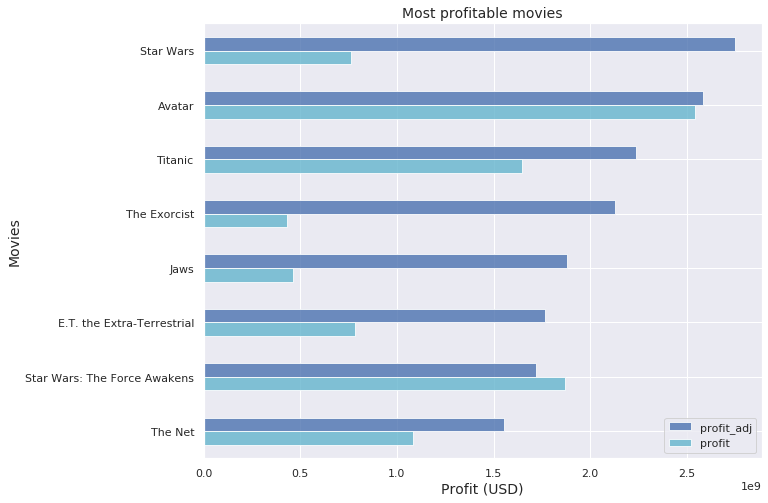

In [62]:
# Extracting the dataframe grouped by movie titles
df_profit_movies = df.groupby('original_title')['original_title', 'profit_adj', 'profit'].head()

# Displaying with horizontal barplot
df_profit_movies.sort_values(['profit_adj', 'profit'], ascending = False).head(8).plot(kind = 'barh', 
                                                                                      x = 'original_title', 
                                                                                      alpha = 0.8, 
                                                                                       color = ['b','c']);
# Inverting y axis to have a top-down display
plt.gca().invert_yaxis()
# Graph features
plt.xlabel('Profit (USD)', fontsize = 14)
plt.ylabel('Movies', fontsize = 14)
plt.title('Most profitable movies', fontsize = 14)

The most profitable movie is **Star wars** followed by **Avatar** and **Titanic**. We can see that taking into account the inflation or not has a significant effect on the result. The following bargraph shows the least profitable movies, again, with inflation adjustment:

Text(0.5, 1.0, 'Least profitable movies')

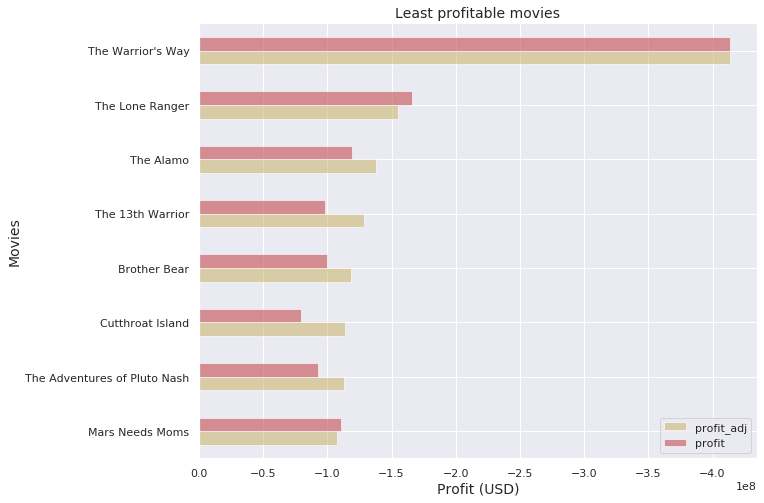

In [22]:
# Displaying with horizontal barplot
df_profit_movies.sort_values(['profit_adj', 'profit'], ascending = False).tail(8).plot(kind = 'barh', 
                                                                                      x = 'original_title', 
                                                                                      alpha = 0.6, 
                                                                                      color = ['y','r']);
# Inverting x axis to have a left-right display
plt.gca().invert_xaxis()
# Graph features
plt.xlabel('Profit (USD)', fontsize = 14)
plt.ylabel('Movies', fontsize = 14)
plt.title('Least profitable movies', fontsize = 14)

It seems that the **Warrior's way** is the least profitable movie and by far.

<a id='Q2'></a>
## 2. What is the distribution of all movies profits

Let's see what is the distributon of the adjusted profits for the whole dataset:

Text(0.5, 1.0, 'Distribution of profits')

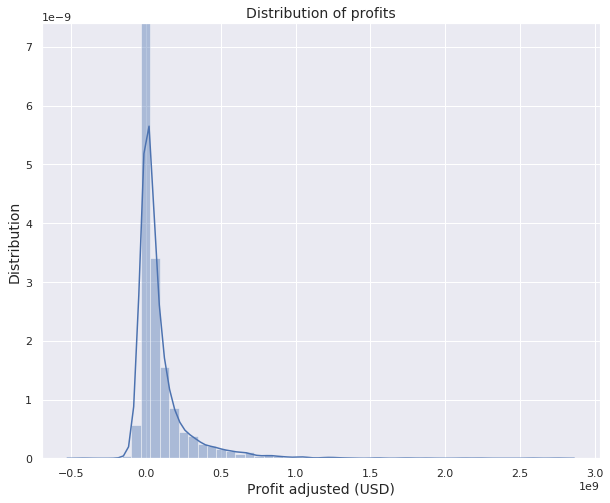

In [63]:
# Displaying the distribution of the profits
sns.distplot(df[('profit_adj')], bins = 50)
# Graph features
plt.xticks(rotation = 0)
plt.xlabel('Profit adjusted (USD)', fontsize = 14)
plt.ylabel('Distribution', fontsize = 14)
plt.title('Distribution of profits', fontsize = 14)

We can see that the distribution is **positively skewed** with a steep slope.

<a id='Q3'></a>
## 3. Are the most profitable movies also the better rated ?

To measure the movie rating, the dataset provides the popularity, the average vote and the vote count. We will display the popularity and vote average in function of the profit with an hexbin plot:

x axis : Profit - adjusted (USD)
y axis : Popularity
z axis : vote_average


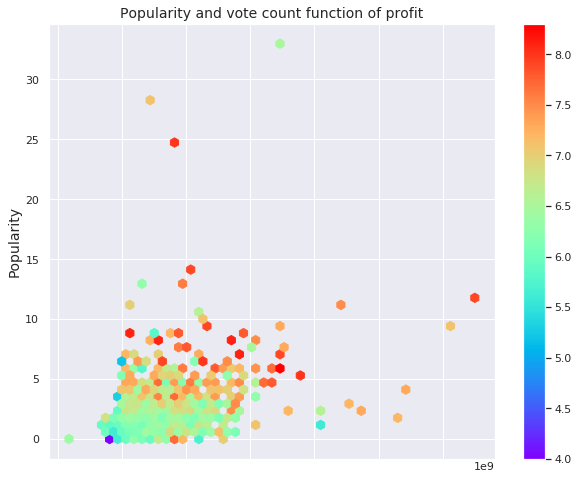

In [72]:
# Creating hexbin graph
df.plot(kind = 'hexbin', x = 'profit_adj', y = 'popularity', C = 'vote_average', cmap = 'rainbow', gridsize = 50)
# Graph features
plt.xlabel('Profit - adjusted (USD))', fontsize = 14)
plt.ylabel('Popularity', fontsize = 14)
plt.title('Popularity and vote count function of profit', fontsize = 14)
print("x axis : Profit - adjusted (USD)\ny axis : Popularity\nz axis : vote_average")

The correlation between profit and popularity seems to exist but it is not obvious. Same observation for the correlation between profit and vote_average. We can calculate the Pearson's r factor to check the correlations between these parameters: 

In [73]:
df.corr(method = 'pearson')[['profit_adj', 'vote_average', 'vote_count', 'popularity']] \
.loc[['profit_adj', 'vote_average', 'vote_count', 'popularity']]

,profit_adj,vote_average,vote_count,popularity
profit_adj,1.000000,0.288794,0.613670,0.516316
vote_average,0.288794,1.000000,0.387370,0.317973
vote_count,0.613670,0.387370,1.000000,0.779752
popularity,0.516316,0.317973,0.779752,1.000000


There is a **small correlation between profit and popularity** (r = 0.52). **The correlation of profit with the vote average is very poor**  (r = 0.29). However, there seems to be a **small correlation between profit and vote count** (r = 0.61).   
It may be possible that more popular the movie, the more people vote (this is supported by the correlation factor between popularity and vote count : r = 0.78). But there is no significant correlation between vote average and vote count (r = 0.39).
The most profitable movie is not necessarily the most rated. The number of voting people can be a lurking variable.

<a id='Q4'></a>
## 4. During which months are the most profitable movies released ?

To answer that question we can create a column in our dataset containing the month of release of each movie. Since we have the exact release date in datetime format, we can extract the month.

Text(0.5, 1.0, 'Mean profit (adjusted) per month')

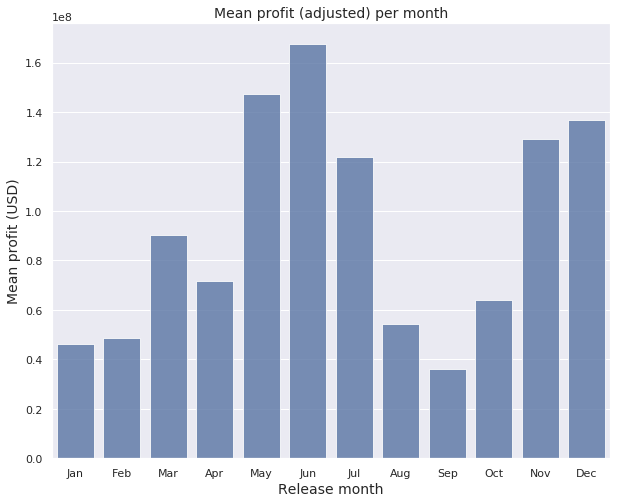

In [76]:
# Creating a column with month (integer format)
df['release_month'] = df['release_date'].dt.month  # datetime library is needed to extract the month from a datetime object.

# Grouping by month and making a list out of it. 
mean_profit_count = list(df.groupby('release_month')['profit_adj'].mean())
# Creating the list of months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Ploting the results
sns.barplot(x = months, y = mean_profit_count, color = "b", alpha = 0.8);
# Graph features
plt.xlabel('Release month', fontsize = 14)
plt.ylabel('Mean profit (USD)', fontsize = 14)
plt.title('Mean profit (adjusted) per month', fontsize = 14)

We can see that the most profitable movies are released **before summer** and at the **end of the year**. This is not surprising as more people are in holidays in summer break and before Christmas, so movie companies may try to release the most anticipated movies in this period.

<a id='Q5'></a>
## 5. What are the genres that generated the most profits ?

To perform this analysis, we will write a function that generates a dataframe giving, for each genre, the number of movies and the total profit.   
It is difficult to say that the profit generated by a movie is equally distributed on each genre. There is generally a main genre and secondary genres. To answer that question, we can simply sum all the profits from the movies featuring one specific genre and compare it to the others. The obtained result won't be the total profits generated by one genre but the total profit of all movies continaing this genre.   
As the following questions need a similar function, we can write it so that it is applicable on other features like cast, director and production companies.

In [78]:
# Function that generates a dataframe with the specified feature (genres, cast...), the movie count and the total profit
def generate_profit_by_feature(dataframe, feature):
    # Reseting the index so that the index corresponds to the row number
    data = dataframe.reset_index()
    
    # Creating a set of unique str appearing in genres column
    genres_list = set(np.hstack(data[feature]))
    
    # Storing the feature, movies count and total profit in a dataframe
    global_list = []
    for genre in genres_list:
        count = 0          # variable to store the number of movies
        total_profit = 0   # variable to store the sum of profits
        row = 0            # variable to find the row (reset_index necessary)
        for element in data[feature]:
            if genre in element:
                count += 1
                total_profit += data['profit_adj'][row]
            row += 1
        global_list.append([genre, count, total_profit])
    
    return pd.DataFrame(global_list, columns = [feature, 'nb_movies', 'sum_profit_adj']).set_index(feature) 

# Applying the function on genres
df_genres = generate_profit_by_feature(df, 'genres')
df_genres.sort_values(['sum_profit_adj'], ascending = False).head()

,nb_movies,sum_profit_adj
genres,,
Adventure,746,142194666495
Action,1078,139676678190
Drama,1747,116820507371
Comedy,1347,111519336242
Thriller,1197,100603648248


Text(0.5, 1.0, 'Total profit generated by genre')

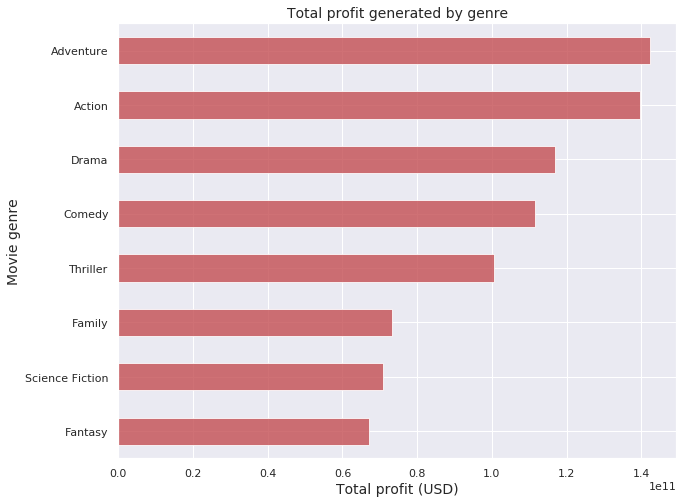

In [87]:
# Ploting the results
df_genres['sum_profit_adj'].sort_values(ascending = False).head(8).plot(kind = 'barh', x = 'genres', color = "r", alpha = 0.8)
# Graph displays
plt.gca().invert_yaxis()
plt.xlabel('Total profit (USD)', fontsize = 14)
plt.ylabel('Movie genre', fontsize = 14)
plt.title('Total profit generated by genre', fontsize = 14)

**Adventure** and **action** are the genres that have generated the highest profits.

<a id='Q6'></a>
## 6. Is there is a correlation between profits and number of movies for each genre ?

We could see if there is a correlation between the mean profit by genre and the number of movies per genre.

Text(0.5, 1.0, 'Total profit function of number of movies')

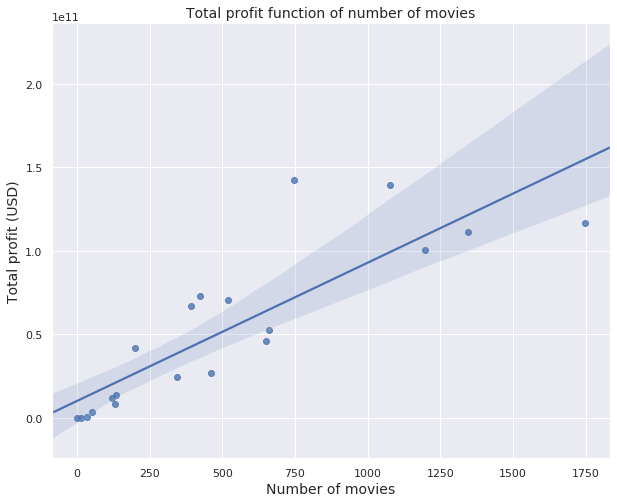

In [88]:
sns.regplot(x = df_genres['nb_movies'], y = df_genres['sum_profit_adj'], color = 'b')
# Graph features
plt.xlabel('Number of movies', fontsize = 14)
plt.ylabel('Total profit (USD)', fontsize = 14)
plt.title('Total profit function of number of movies', fontsize = 14)

In [81]:
# Calculating the Pearson's r.
df_genres.corr()

,nb_movies,sum_profit_adj
nb_movies,1.000000,0.852169
sum_profit_adj,0.852169,1.000000


**There seems to be a correlation between number of movies per genre and mean profit per genre**. This is not surprising as, for a specific genre, the more movies are made, the more is the profit obtained. However, **Adventure** movies seem to have a better ratio total profit / number of movies.

<a id='Q7'></a>
## 7. What are the casts, directors and production companies the most profitable ?

To answer this question, we can re-use the function we have written for the genres analysis.

##### **TOP Performers**

In [83]:
df_cast = generate_profit_by_feature(df, 'cast')
df_cast.sort_values(['sum_profit_adj'], ascending = False).head(8)

,nb_movies,sum_profit_adj
cast,,
Harrison Ford,34,11808415332
Tom Cruise,33,8361768620
Tom Hanks,34,8079464501
Carrie Fisher,7,7263715470
Emma Watson,12,7212039540
Daniel Radcliffe,12,7071883859
Mark Hamill,5,7028274588
Rupert Grint,9,6974591013


The most profitable actor (based on the total profit of the movie he played in) is **Harrison Ford**. We can see that the most appearing performer is not necessarilt the one who cumulated the highest profit movies. Carrie Fischer for instance, despite of the low number of movies she played in, is in 4th position in our classification. This is most likely due to her role in Star Wars which is the most profitable movie when accouting for USD inflation.

##### **TOP Directors**

In [84]:
df_dir = generate_profit_by_feature(df, 'director')
df_dir.sort_values(['sum_profit_adj'], ascending = False).head(8)

,nb_movies,sum_profit_adj
director,,
Steven Spielberg,28,13168609363
James Cameron,8,6296578359
George Lucas,6,5844159209
Peter Jackson,11,5645491691
Robert Zemeckis,15,4335995167
Chris Columbus,9,4171046474
Michael Bay,11,3958675887
Wolfgang Reitherman,5,3490935372


The most profitable director (based on the total profit of the movie he directed) is **Steven Spielberg**. As for cast, there are some directors such as James Cameron or Georges Lucas who directed few movies but high profitable ones. 
##### **TOP Production companies**

In [85]:
df_prod = generate_profit_by_feature(df, 'production_companies')
df_prod.sort_values(['sum_profit_adj'], ascending = False).head(8)

,nb_movies,sum_profit_adj
production_companies,,
Warner Bros.,324,43922987911
Universal Pictures,327,42605603101
Paramount Pictures,266,38105201171
Twentieth Century Fox Film Corporation,201,37751899669
Walt Disney Pictures,117,25554287266
Columbia Pictures,178,20317010538
Amblin Entertainment,50,16390766869
New Line Cinema,150,15912625108


The most profitable production companies (based on the total profit of the movie it produced) is **Warner Bros**. 

<a id='conclusions'></a>
## Conclusions

#### **Answers to research questions:**

<li><a href="#Q1">1. What are the most and the least profitable movies ?</a></li>

The most profitable movie is **Star wars** followed by **Avatar** and **Titanic**. The **Warrior's way** is the least profitable movie.

<li><a href="#Q2">2. What is the distribution of all movies profits ?</a></li>

We can see that the distribution is **positively skewed** with a steep slope.

<li><a href="#Q3">3. Are the most profitable movies also the better rated ?</a></li>

The **correlation between profit and popularity is not high**. The correlation between profit and vote average is even poorer. That seems to indicate that the most profitable movies are not necessarily the best rated.    
Furthermore, there is a slight correlation between profit and vote count and between popularity and vote count (but no real correlation between vote average and vote count).

<li><a href="#Q4">4. During which months are the most profitable movies released ?</a></li>

The most profitable movies are released **before summer** and at the **end of the year**.

<li><a href="#Q5">5. What are the genres that generated the most profits ?</a></li>

**Adventure** and **action** are the genres that have generated the highest profits.

<li><a href="#Q6">6. Is there is a correlation between profit and number of movies for each genre ?</a></li>

Their seems to be a correlation between number of movies per genre and mean profit per genre. **Adventure** movies have a better ratio between total profit and number of movies.

<li><a href="#Q7">7. What are the casts, directors and production companies which have generated the most profits ?</a></li>

The most profitable actor (based on the total profit of the movie he played in) is **Harrison Ford**. The most appearing cast is not the one who cumulated the highest profit movies. There are some actors/actresses who played in few movies but high profitable ones.

The most profitable director (based on the total profit of the movie he directed) is **Steven Spielberg**. As for cast, there are some directors such as James Cameron or Georges Lucas who directed few movies but high profitable ones.   

The most profitable production companies (based on the total profit of the movie it produced) is **Warner Bros**.

#### **Limitations:**

- The missing budget, revenue and the outliers points represent more than half of the dataset rows. Although the remaining data were sufficient to conduct our analysis, we might have missed some information.
- We don't have information on how the revenue is calculated. Does it take into account the cinema entries only or does it take also the by-products ? 
- In the same way, we don't know if the budget include, for example, advertising or copyright purchase.
- A lot of movies have several genres, performers, directors and production companies. The profit made by one movie cannot be considered equally distributed on all performers. It is then not really accurate to find the most profitable features per movie.
- We don't really know ho the popularity and vote average are determined.

#### **References:**

https://www.kaggle.com/tmdb/tmdb-movie-metadata

https://pandas.pydata.org/pandas-docs/stable/reference/

https://seaborn.pydata.org/

https://matplotlib.org/

https://en.wikipedia.org/wiki/Low-budget_film 

https://stackoverflow.com/